In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.dates as mdates

import matplotlib as mpl
sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,3)
mpl.rcParams['figure.dpi'] = 100

base_folder = "../../spcl/serverless-benchmarks/consistent-statistics"

dfo = pd.read_pickle("data/short/pickle")
dfo = dfo.dropna()
dfo['function_stop'] = pd.to_datetime(dfo['function_stop'], unit='s')
dfo['function_start'] = pd.to_datetime(dfo['function_start'], unit='s')
dfo['invoke_start'] = pd.to_datetime(dfo['invoke_time'], unit='s')
dfo['return_stop'] = pd.to_datetime(dfo['return_time'], unit='s')
dfo["isCold"] = dfo["isCold"].map({'True': True, 'False': False})
dfo = dfo.set_index("function_start").sort_index()
df = dfo
df["wrongCold"] = ((df["type"] == "Warm") & (df["isCold"]))

df["internal_time"] = df["function_stop"] - df.index
df["external_time"] = df["return_stop"] - df["invoke_start"]
df["test"] = df["func_name"].str.split(pat="_").str[0]

null_ts = df['invoke_start'].min()
df["function_start_norm"] = df.index - null_ts
df["hours_since_start"] = df["function_start_norm"].dt.total_seconds() / 3600
df["dow"] = df.index.day_of_week
df["hod"] = df.index.hour
df["how"] = (df["dow"] * 24) + df["hod"]
df["msm"] = (df.index.hour * 60) + (df.index.minute)
float = df.loc[df["test"] == "float"]
matrix = df.loc[df["test"] == "matrix"]
ml = df.loc[df["test"] == "ml"]

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

In [3]:
sns.set_palette(sns.color_palette("colorblind"))

In [4]:
linestyle = {
    512:'solid', 
    256:'dotted',
    128:'dashed',
    1024:'dashed'
}
palette = sns.color_palette("colorblind")
color = {
    512: palette[2], 
    256: palette[1],
    128: palette[0],
    1024: palette[3],
}

In [5]:
case = float
onlyCold = case.loc[case["isCold"]]
onlyWarm = case.loc[case["isCold"] == False]
onlyWarm128 = onlyWarm.loc[onlyWarm["size"] == 128]

In [6]:
df["wrongCold"] = (df["type"] == "Warm") & (df["isCold"] == True)
df["tmp_fix"] = 1
wrong_sum = df[["isCold", "wrongCold", "tmp_fix"]].resample("H").sum(numeric_only=True).dropna()
wrong_sum["dow"] = wrong_sum.index.day_of_week
wrong_sum["hod"] = wrong_sum.index.hour
wrong_sum["how"] = (wrong_sum["dow"] * 24) + wrong_sum["hod"] 
wrong_sum["freq"] = wrong_sum["wrongCold"] / wrong_sum["tmp_fix"]

TeX  NOT subset; don't know how to subset; dropped


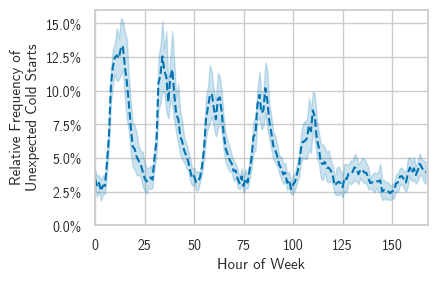

In [7]:
ax = sns.lineplot(data=wrong_sum, x="how", y=wrong_sum["wrongCold"] / wrong_sum["tmp_fix"], color=color[128], linestyle=linestyle[128])
#ax = sns.lineplot(data=wrong_sum, x="how", y="freq", color="yellow", linestyle=linestyle[128])
plt.xlim((0,168))
plt.ylim((0, 0.16))
plt.xlabel("Hour of Week")
plt.ylabel("Relative Frequency of\nUnexpected Cold Starts")
#plt.title("Wrong Cold Starts")
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
save_fig(ax, "wrongColdWeekly")

In [8]:
print(wrong_sum.loc[(wrong_sum["how"] > 125) | (wrong_sum["how"] < 0)]["freq"].mean())

print(wrong_sum.loc[(wrong_sum["how"]%24 > 20) | (wrong_sum["how"]%24 < 8)]["freq"].mean())

print(wrong_sum.loc[((wrong_sum["how"]%24 > 9) & (wrong_sum["how"]%24 < 17)) & (wrong_sum["how"] < 125)]["freq"].mean())

print(wrong_sum.loc[(wrong_sum["how"] > 9) & (wrong_sum["how"] < 17)]["freq"].mean())

0.035338841923662156
0.03711612525229475
0.09644039455584148
0.12337292030790187


Text(0.5, 0, 'Minute of Day')

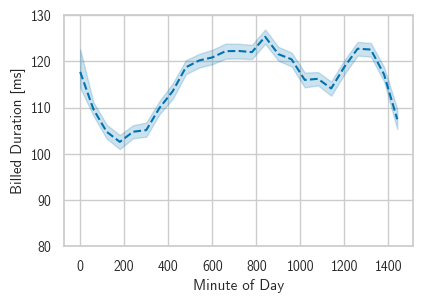

In [9]:
#tobiasComplains = onlyWarm128.copy()
#only0 = tobiasComplains.loc[onlyWarm128["hod"] == 0]
#only0["hod"] = 24
#tobiasComplains = only0.append(tobiasComplains)
def custom_round(x, base=60):
    return int(base * round(__builtins__.float(x)/base))

custom_y = onlyWarm128.msm.apply(custom_round)

ax = sns.lineplot(data=onlyWarm128, y="google_time", x=custom_y, color=color[128], linestyle=linestyle[128])
#plt.xlim((0,24))
plt.ylim((80,130))
plt.ylabel("Billed Duration [ms]")
plt.xlabel("Minute of Day")
#save_fig(ax,"floatHod128Warm")

/tmp/ipykernel_16540/3111154837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3111154837.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)
TeX  NOT subset; don't know how to subset; dropped


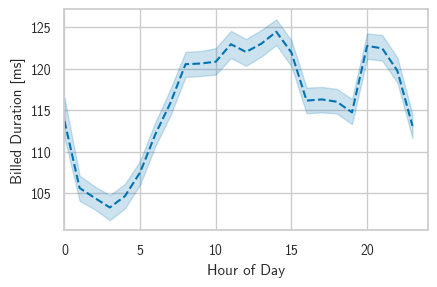

In [10]:
tobiasComplains = onlyWarm128.copy()
only0 = tobiasComplains.loc[onlyWarm128["hod"] == 0]
only0["hod"] = 24
tobiasComplains = only0.append(tobiasComplains)
ax = sns.lineplot(data=onlyWarm128, y="google_time", x="hod", color=color[128], linestyle=linestyle[128])
plt.xlim((0,24))
plt.ylabel("Billed Duration [ms]")
plt.xlabel("Hour of Day")
save_fig(ax,"floatHod128Warm")

In [11]:
# Figure out average latency between 0-5 and 9-15
print(onlyWarm128.loc[(onlyWarm128["hod"] > 23) | (onlyWarm128["hod"] < 6)]["google_time"].mean())
print(onlyWarm128.loc[(onlyWarm128["hod"] >7) & (onlyWarm128["hod"] < 16) ]["google_time"].mean())

# Figure out min/max average duration of weekday
print([str(dow) + ": " + str(onlyWarm128.loc[onlyWarm128["dow"] == dow]["google_time"].mean()) for dow in onlyWarm128["dow"].unique()])

""""
Old Results
106.35131109387122
122.22372190250071
['0:116.74506458688764', '1:116.24184782608695', '2:116.63528168622435', '3:115.62345288123885', '4:115.17502278942571', '5:112.46611898329382', '6:114.73727952167414
"""

106.50351496145302
122.0435150253675
['0: 117.28716571909875', '1: 116.85907242447715', '2: 116.98934094694266', '3: 115.42228878429135', '4: 115.2171215302076', '5: 113.8609731876862', '6: 115.29051973051011']


'"\nOld Results\n106.35131109387122\n122.22372190250071\n[\'0:116.74506458688764\', \'1:116.24184782608695\', \'2:116.63528168622435\', \'3:115.62345288123885\', \'4:115.17502278942571\', \'5:112.46611898329382\', \'6:114.73727952167414\n'

Text(0.5, 0, 'Day of Week')

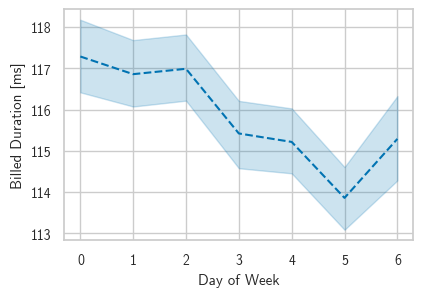

In [12]:
ax = sns.lineplot(data=onlyWarm128, y="google_time", x="dow", color=color[128], linestyle=linestyle[128])
plt.ylabel("Billed Duration [ms]")
plt.xlabel("Day of Week")

TeX  NOT subset; don't know how to subset; dropped


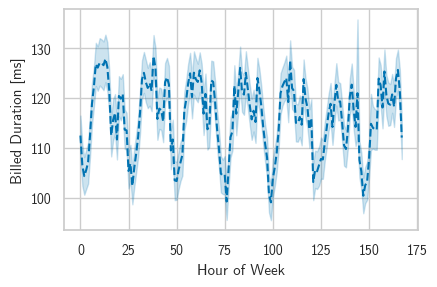

In [13]:
ax = sns.lineplot(data=onlyWarm128, y="google_time", x="how", color=color[128], linestyle=linestyle[128])
plt.ylabel("Billed Duration [ms]")
plt.xlabel("Hour of Week")
save_fig(ax,"floatHow128Warm")

/tmp/ipykernel_16540/300772970.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.ecdfplot(onlyWarm, x="google_time", hue="size", hue_order=sorted(onlyWarm["size"].unique()), palette=sns.color_palette("colorblind"))
/tmp/ipykernel_16540/300772970.py:6: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = ax.legend_.legendHandles[::-1]
TeX  NOT subset; don't know how to subset; dropped


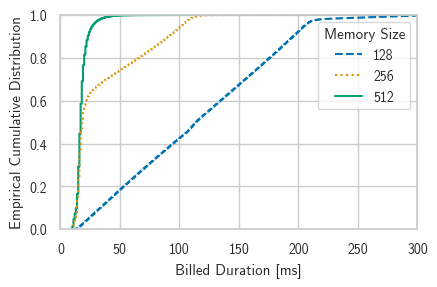

In [14]:
ax = sns.ecdfplot(onlyWarm, x="google_time", hue="size", hue_order=sorted(onlyWarm["size"].unique()), palette=sns.color_palette("colorblind"))

# Change linestyle
lss = ['solid', 'dotted', 'dashed']

handles = ax.legend_.legendHandles[::-1]

for line, ls, handle in zip(ax.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)

plt.ylabel("Empirical Cumulative Distribution")
plt.xlabel("Billed Duration [ms]")
plt.xlim(0, 300)
plt.gca().get_legend().set_title("Memory Size")

save_fig(ax,"durationSizeEcdf")

/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)
TeX  NOT subset; don't know how to subset; dropped


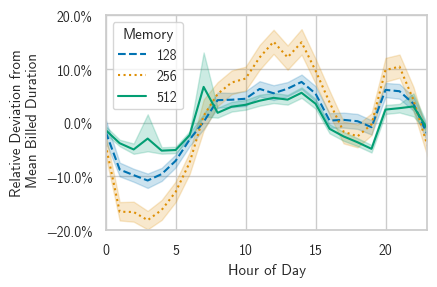

/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)
TeX  NOT subset; don't know how to subset; dropped


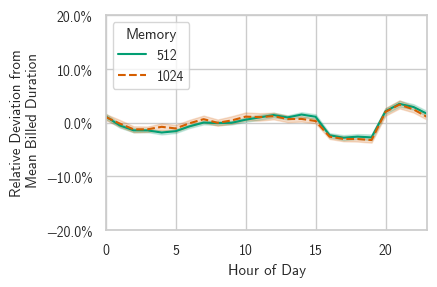

/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)


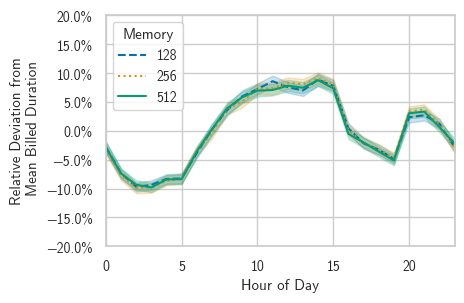

/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)


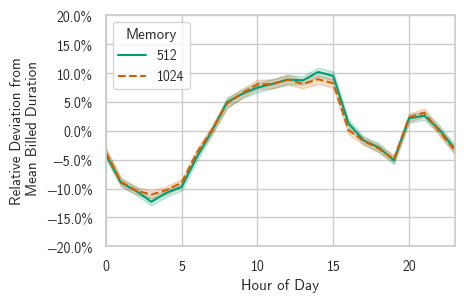

In [15]:
def showMemImpact(input, isCold, zero_is_24=False, ylim=True):
    msi = {}
    if zero_is_24:
        tobiasComplains = input.copy()
        only0 = tobiasComplains.loc[tobiasComplains["hod"] == 0]
        only0["hod"] = 24
        tobiasComplains = only0.append(tobiasComplains)
        msi = tobiasComplains.loc[input["isCold"] == isCold]
    else:
        msi = input.loc[input["isCold"] == isCold]
    msi["size"].unique()
    fSize = {s: msi.loc[msi["size"] == s] for s in sorted(msi["size"].unique(), reverse=True)}
    #averages = [{ s: msi.loc[msi["size"] == s].mean() } for s in msi["size"].unique()]
    #averages

    for elem in sorted(fSize.keys()):
        df = fSize[elem]
        mean = df["google_time"].mean()
        sns.lineplot(df, x="hod", y=(df["google_time"] - mean)/mean, label=elem, linestyle=linestyle[elem], color=color[elem])
    plt.gca().get_legend().set_title("Memory Size")
    plt.ylabel("Relative Deviation from\n Mean Billed Duration")
    plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    plt.xlabel("Hour of Day")
    plt.xlim((0, 23))
    if ylim:
        plt.ylim((-0.2, 0.2))
    plt.legend(title="Memory", loc="upper left")

showMemImpact(float, False, True)
save_fig(plt.gca(), "floatRelativeChange")
plt.show()
showMemImpact(ml, False, True)
save_fig(plt.gca(), "mlRelativeChange")
plt.show()
showMemImpact(float, True, True)
plt.show()
showMemImpact(ml, True, True)
plt.show()


/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)


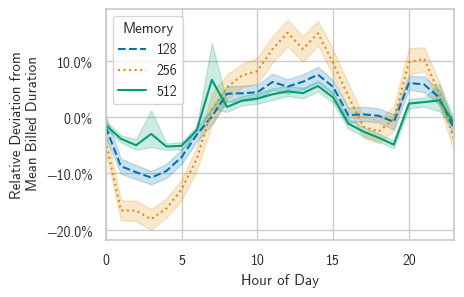

/tmp/ipykernel_16540/3273930345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only0["hod"] = 24
/tmp/ipykernel_16540/3273930345.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tobiasComplains = only0.append(tobiasComplains)


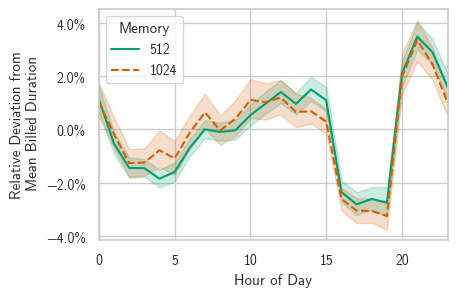

In [16]:
showMemImpact(float, False, True, False)
plt.show()
showMemImpact(ml, False, True, False)
plt.show()

# Long Term Trends

In [17]:
import statsmodels.tsa.seasonal as seasonal
rs_1h = onlyWarm128[["google_time"]].resample("H").mean(numeric_only=True).dropna()
stl = seasonal.STL(rs_1h, period=24, robust=True)
res24 = stl.fit()

In [18]:
residuals = res24.resid
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
IQRF = 4

print("Points that were extremely uncommon")
outsideIQR = residuals.loc[(residuals > IQRF*IQR) | (residuals < -IQRF*IQR)]
# Filter out the stuff around 18.12.
outsideIQR = outsideIQR[3:]
print(outsideIQR)

Points that were extremely uncommon
function_start
2023-01-01 00:00:00    30.518409
2023-01-03 06:00:00   -32.874669
2023-01-27 03:00:00   -26.461640
2023-01-29 00:00:00    73.640902
2023-02-01 09:00:00    26.272199
Name: resid, dtype: float64


['2023-01-09T07:00:00', '2023-01-23T06:00:00', '2023-02-07T01:00:00', '2023-02-17T06:00:00']


TeX  NOT subset; don't know how to subset; dropped


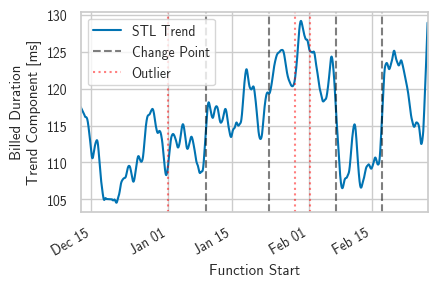

In [19]:
import ruptures as rpt
from datetime import datetime

signal = np.array(rs_1h["google_time"].tolist())
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=8)
result = result[:-1]

changePoints = []
for r in result:
    changePoints.append(rs_1h.iloc[r-1])

print([c.name.isoformat() for c in changePoints])

ax = sns.lineplot(res24.trend, label="STL Trend", color=color[128], linestyle="solid")

for ind, p in enumerate(changePoints):
    plt.axvline(p.name, alpha=0.5, color="black", linestyle="dashed", label= "Change Point" if ind == 0 else None)
for ind, f in enumerate(outsideIQR.index):
    plt.axvline(f,0, outsideIQR[f], alpha=0.5, color="red", linestyle="dotted", label= "Outlier" if ind == 0 else None)

# for ind, label in enumerate(ax.get_xticklabels()):
#     if ind % 3 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
ax.xaxis.set_major_locator(mdates.AutoDateLocator(interval_multiples=True))
#ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.DAILY, interval=10, dtstart=datetime(2022, 12, 1))))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend(loc="upper left")
plt.xlabel("Function Start")
plt.ylabel("Billed Duration\nTrend Component [ms]")
plt.gcf().autofmt_xdate()
plt.autoscale(enable=True, axis='x', tight=True)
save_fig(plt.gca(), "longTermTrend")